# Promoter Sequence Extraction and Analysis: Feature Extraction Workflow

This notebook focuses on the extraction of promoter sequences for coding genes, followed by a comprehensive analysis of these sequences. We are processing the human genome and analyzing key features and motifs in the promoter regions. The primary goal is to ensure the completeness, quality, and biological relevance of the extracted promoter sequences and associated features.

## 1. **Loading Genomic Data**

- **Genome Data**: The FASTA file of the human genome is loaded into a dictionary, where each chromosome is a key, and its sequence is the corresponding value. This allows efficient access to the genome sequence for extracting promoter regions.
- **Gene Annotations**: The GTF file is loaded to retrieve gene annotations, focusing on **coding genes**. This file contains information about gene start and end positions, as well as other genomic features.

## 2. **Filtering for Relevant Chromosomes**

- We filter out genes located on chromosomes **1-22**, **X**, and **Y**. This ensures that the analysis focuses on the main human chromosomes and avoids other non-relevant chromosomes (e.g., mitochondrial DNA).

## 3. **Promoter Sequence Extraction**

- **Promoter Region**: For each coding gene, the **promoter sequence** is extracted from **2 kb upstream of the Transcription Start Site (TSS)**. This is the typical region where key regulatory elements, including transcription factor binding sites, are located.
  
  - If the gene start position is close to the beginning of the chromosome, the promoter length is adjusted to avoid negative positions.
  
## 4. **Quality Assurance & Feature Extraction**

For each extracted promoter sequence, we perform several key analyses to assess the quality and biological relevance of the promoter regions:

### 4.1 **Promoter Length**
- The script checks if the promoter sequence is at least **2 kb** in length. If the promoter is shorter than 2 kb, it is flagged as invalid.
  
### 4.2 **GC Content**
- **GC Content** is calculated for each promoter sequence. High GC content in the promoter is often associated with certain transcriptional properties, such as stability and transcription factor binding efficiency.

### 4.3 **TATA Box Detection**
- The presence of a **TATA box** (motif: `TATAAA` or similar variants) is detected. The TATA box is a core component of the transcription initiation complex and is essential for the binding of the transcription machinery.

### 4.4 **CpG Island Detection**
- A simplified method for detecting **CpG islands** is implemented. CpG islands are regions with high CpG content and are often found in gene promoters, where they play a role in gene regulation.

### 4.5 **Missing Nucleotides (N's)**
- We check for the presence of **missing nucleotides** in the promoter sequence (denoted as `N`). The presence of 'N' typically indicates gaps in the sequence due to incomplete sequencing or assembly issues.

### 4.6 **Strand Information**
- The strand information (positive or negative) is recorded to indicate the direction of transcription, which influences the directionality of the promoter and associated regulatory elements.

## 5. **Storing Extracted Data**

The extracted promoter features and associated quality checks are stored in a **pandas DataFrame**. The following columns are included:

- **Gene_ID**: The unique identifier for each gene.
- **Chromosome**: The chromosome where the gene is located.
- **Promoter_Sequence**: The extracted promoter sequence (2 kb upstream of TSS).
- **GC_Content**: The GC content of the promoter sequence.
- **Gene_Length**: The length of the gene (calculated as `end - start` position).
- **TATA_Box**: Presence of a TATA box in the promoter (Yes/No).
- **CpG_Island**: Presence of a CpG island in the promoter (Yes/No).
- **Strand**: The strand orientation of the gene (positive or negative).
- **Valid_Promoter_Length**: Whether the promoter length is valid (>= 2 kb).
- **Missing_Nucleotides**: Whether there are missing nucleotides in the promoter sequence (Yes/No).

This structured DataFrame enables easy access to the extracted data for further analysis.

## 6. **Saving Results**

Once the data is collected, it is saved into a **CSV file** (`coding_genes_promoter_features_quality_checked.csv`) for future use. This allows for easy sharing and further processing of the extracted features.

## 7. **Initial Quality Checks & Reporting**

For each gene, the following quality checks are performed and printed:
- Gene ID
- Chromosome
- Promoter length
- GC content
- Presence of the TATA box and CpG island
- Missing nucleotides (if any)
- Validity of promoter length (>= 2 kb)

## 8. **Descriptive Statistics**

After the extraction and quality checks, the following **descriptive statistics** are generated:
- Overview of **gene length** and **GC content** across the dataset.
- Helps identify trends or anomalies in gene structure and promoter composition.

## 9. **Advanced Analysis & Motif Quantification**

### 9.1 **Motif Detection**
In addition to the **TATA box** and **CpG islands**, other potential promoter motifs are considered:
- **GC-rich motifs**: Sequences rich in GC content, often found in promoters.
- **Initiator elements (Inr)**: Key elements involved in the initiation of transcription.
- **CTCF binding sites**: DNA motifs recognized by CTCF, a key transcription factor.

### 9.2 **Quantifying Motif Occurrences**
Each motif is quantified in terms of:
- **Motif Presence**: Whether the motif is found in the promoter sequence.
- **Motif Count**: The number of occurrences of the motif in the promoter.
- **Motif Density**: The number of motif occurrences per unit length of the promoter sequence.

This summary should help clarify the entire process, from loading data to extracting features and performing quality checks, and is structured in a way that will help you understand and expand upon the analysis in your notebook.


In [5]:
import os
import pandas as pd
from Bio import SeqIO

# Constants for file paths
FASTA_FILE = "Homo_sapiens.GRCh38.dna.primary_assembly.fa"  # Path to the genome FASTA file
GTF_FILE = "Homo_sapiens.GRCh38.110.gtf"  # Path to the GTF file
PROMOTER_LENGTH = 2000  # Define promoter region (e.g., 2kb upstream)

# Load genome assembly from FASTA file
def load_genome(fasta_path):
    print("Loading genome from FASTA file...")
    genome = {rec.id: str(rec.seq) for rec in SeqIO.parse(fasta_path, "fasta")}
    return genome

# Load and process the GTF file (annotations)
def load_gtf(gtf_path):
    print("Loading and processing GTF file...")
    columns = ['seqname', 'source', 'feature', 'start', 'end', 
               'score', 'strand', 'frame', 'attribute']
    
    gtf_df = pd.read_csv(gtf_path, sep='\t', comment='#', header=None, names=columns, low_memory=False)
    gtf_df[['start', 'end']] = gtf_df[['start', 'end']].astype(int)
    
    # Filter out the rows that are not genes (only keep 'gene' entries)
    gtf_df = gtf_df[gtf_df['feature'] == 'gene']
    return gtf_df

# Extract promoter sequence for a given gene
def extract_promoter_sequence(genome, gtf_row):
    chrom = gtf_row['seqname']
    strand = gtf_row['strand']
    start = gtf_row['start']
    end = gtf_row['end']
    
    # Define the promoter region
    if strand == '+':
        promoter_start = max(0, start - PROMOTER_LENGTH)  # Ensure we don't go below 0
        promoter_end = start
    else:  # For negative strand, the promoter is upstream of the end
        promoter_start = end
        promoter_end = min(len(genome[chrom]), end + PROMOTER_LENGTH)
    
    # Extract the sequence
    promoter_sequence = genome[chrom][promoter_start:promoter_end]
    
    return promoter_sequence

# Save promoter sequences as a CSV file
def save_promoter_sequences(promoter_sequences, output_file):
    promoter_df = pd.DataFrame(promoter_sequences)
    
    # Extract chromosome number (only from chromosomes 1-22, X, Y)
    promoter_df['chromosome_number'] = promoter_df['seqname'].apply(lambda x: x if x in [str(i) for i in range(1, 23)] + ['X', 'Y'] else 'Unknown')
    
    # Save to CSV
    promoter_df.to_csv(output_file, index=False)
    print(f"Promoter sequences saved to {output_file}")
    
    # Print the number of records (rows in the CSV)
    print(f"Number of records: {len(promoter_df)}")

# Main workflow
def main():
    # Load the genome (FASTA) and GTF annotation data
    genome = load_genome(FASTA_FILE)
    gtf_df = load_gtf(GTF_FILE)
    
    # Filter for only chromosomes 1-22, X, Y and protein-coding genes
    relevant_chromosomes = [str(i) for i in range(1, 23)] + ['X', 'Y']
    coding_genes = gtf_df[gtf_df['seqname'].isin(relevant_chromosomes)]  # Filter for relevant chromosomes
    coding_genes = coding_genes[coding_genes['attribute'].str.contains('gene_biotype "protein_coding"')]  # Filter for protein-coding genes
    
    # Extract promoter sequences for each gene
    promoter_sequences = []
    for _, row in coding_genes.iterrows():
        promoter_sequence = extract_promoter_sequence(genome, row)
        
        # Extract Gene Biotype and Gene Type from the attribute column
        gene_biotype = row['attribute'].split('gene_biotype "')[1].split('"')[0] if 'gene_biotype' in row['attribute'] else 'Unknown'
        gene_type = row['attribute'].split('gene_type "')[1].split('"')[0] if 'gene_type' in row['attribute'] else 'Unknown'
        
        # Store the results in the list
        promoter_sequences.append({
            'gene_id': row['attribute'],
            'seqname': row['seqname'],
            'strand': row['strand'],
            'promoter_sequence': promoter_sequence,
            'gene_biotype': gene_biotype,
            'gene_type': gene_type
        })
    
    # Save the promoter sequences to a CSV file
    save_promoter_sequences(promoter_sequences, "promoter_sequences.csv")

# Run the script
main()


Loading genome from FASTA file...
Loading and processing GTF file...
Promoter sequences saved to promoter_sequences.csv
Number of records: 20033


In [7]:
import pandas as pd

# Load the promoter_sequences.csv file
file_path = "promoter_sequences.csv"  # Update with your actual file path
promoter_df = pd.read_csv(file_path)

# Calculate the sequence lengths
promoter_df['sequence_length'] = promoter_df['promoter_sequence'].apply(len)

# Calculate maximum, minimum, and average sequence length
max_length = promoter_df['sequence_length'].max()
min_length = promoter_df['sequence_length'].min()
avg_length = promoter_df['sequence_length'].mean()

print(f"Maximum sequence length: {max_length}")
print(f"Minimum sequence length: {min_length}")
print(f"Average sequence length: {avg_length}")


Maximum sequence length: 2000
Minimum sequence length: 2000
Average sequence length: 2000.0


In [13]:
import pandas as pd

# Load the CSV file with promoter sequences
def load_promoter_csv(csv_path):
    print(f"Loading promoter CSV from {csv_path}...")
    df = pd.read_csv(csv_path)
    print(f"Loaded {df.shape[0]} records from the CSV file.")
    return df

# Check for missing nucleotides (N's) in the sequence and return the count
def check_for_missing_nucleotides(promoter_seq):
    return promoter_seq.count('N')

# Main function to check for issues
def check_promoter_issues(csv_file):
    df = load_promoter_csv(csv_file)
    
    # Keep track of any problematic records
    problematic_records = []

    # Loop through the dataframe and check each sequence
    for index, row in df.iterrows():
        promoter_sequence = row['promoter_sequence']
        
        # Check if the promoter sequence is less than 2kb or contains 'N'
        missing_nucleotides_count = check_for_missing_nucleotides(promoter_sequence)
        if len(promoter_sequence) < 2000 or missing_nucleotides_count > 0:
            problematic_records.append({
                'index': index,
                'gene_id': row['gene_id'],
                'promoter_sequence': promoter_sequence,
                'length': len(promoter_sequence),
                'missing_nucleotides_count': missing_nucleotides_count
            })
    
    # If any problematic records were found, print them
    if problematic_records:
        print("Found the following problematic promoter sequences:")
        for record in problematic_records:
            print(f"\nIndex: {record['index']}")
            print(f"Gene ID: {record['gene_id']}")
            print(f"Promoter Sequence (Length: {record['length']}): {record['promoter_sequence']}")
            print(f"Missing Nucleotides: {record['missing_nucleotides_count']}")
    else:
        # If no issues were found, print "We good!"
        print("We good!")

# Run the check function on your promoter sequences CSV
check_promoter_issues("promoter_sequences.csv")


Loading promoter CSV from promoter_sequences.csv...
Loaded 20033 records from the CSV file.
Found the following problematic promoter sequences:

Index: 5122
Gene ID: gene_id "ENSG00000260596"; gene_version "5"; gene_name "DUX4"; gene_source "ensembl_havana"; gene_biotype "protein_coding";
Promoter Sequence (Length: 2000): NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

In [29]:
import pandas as pd
import re

# Constants for file paths
CSV_FILE = "promoter_sequences.csv"  

# Function to load the promoter sequences CSV
def load_promoter_csv(csv_path):
    print(f"Loading promoter CSV from {csv_path}...")
    df = pd.read_csv(csv_path)
    print(f"Loaded {df.shape[0]} records from the CSV file.")
    return df

# Function to check for missing nucleotides (i.e., 'N' in the sequence)
def check_for_missing_nucleotides(promoter_seq):
    return 'N' in promoter_seq

# CpG island detection (CG content > 0.5 indicates a CpG island)
def detect_cpg_island(promoter_seq, threshold=0.009):
    cpg_count = sum([1 for i in range(len(promoter_seq) - 1) 
                     if promoter_seq[i:i+2] == 'CG'])
    cpg_content = cpg_count / len(promoter_seq) if len(promoter_seq) > 0 else 0
    return cpg_content > threshold

# Function to perform quality assurance and detect CpG islands
def perform_quality_assurance(df):
    # Drop records containing missing nucleotides (N's)
    df_clean = df[~df['promoter_sequence'].apply(check_for_missing_nucleotides)].copy()
    print(f"After dropping sequences with missing nucleotides, {df_clean.shape[0]} records remain.")
    
    # Detect CpG islands for each promoter sequence
    df_clean['CpG_Island'] = df_clean['promoter_sequence'].apply(detect_cpg_island)
    
    # Save the updated dataframe to a new CSV file
    updated_csv = "updated_promoter_with_cpg_islands.csv"
    df_clean.to_csv(updated_csv, index=False)
    print(f"Updated dataframe saved to {updated_csv}.")
    
    # Return the cleaned dataframe
    return df_clean

# Function to perform basic visualizations and quality checks
def perform_visualizations(df):
    # Summary of CpG island detection
    cpg_island_count = df['CpG_Island'].sum()
    print(f"Number of promoters with a CpG island detected: {cpg_island_count}")
    
    # Descriptive statistics for the CpG content
    print("\nDescriptive statistics of CpG content:")
    print(df[['promoter_sequence', 'CpG_Island']].describe())

# Main workflow
def main():
    # Load the promoter CSV data
    df = load_promoter_csv(CSV_FILE)
    
    # Perform quality assurance (drop missing nucleotides, detect CpG islands)
    updated_df = perform_quality_assurance(df)
    
    # Perform visualizations on the updated dataframe
    perform_visualizations(updated_df)

# Execute the main function
main()


Loading promoter CSV from promoter_sequences.csv...
Loaded 20033 records from the CSV file.
After dropping sequences with missing nucleotides, 20028 records remain.
Updated dataframe saved to updated_promoter_with_cpg_islands.csv.
Number of promoters with a CpG island detected: 17121

Descriptive statistics of CpG content:
                                        promoter_sequence CpG_Island
count                                               20028      20028
unique                                              19957          2
top     AATCAGAATTAAAGGGAATACATTACAACTGGTAAAACAGAAATAA...       True
freq                                                    4      17121


Loading promoter CSV from promoter_sequences.csv...
Loaded 20033 records from the CSV file.
Updated and cleaned dataframe saved to updated_promoter_features_clean.csv.

Quality Assurance Report:
Number of records with missing nucleotides: 0
Number of valid promoters (>= 2kb): 20028
Number of promoters with a TATA box detected: 119799
Number of promoters with a CpG island detected: 534.0805

Descriptive statistics of Gene Length and GC Content:
       Gene_Length    GC_Content
count      20028.0  20028.000000
mean        2000.0      0.485837
std            0.0      0.076028
min         2000.0      0.180500
25%         2000.0      0.433500
50%         2000.0      0.483000
75%         2000.0      0.533125
max         2000.0      0.781000


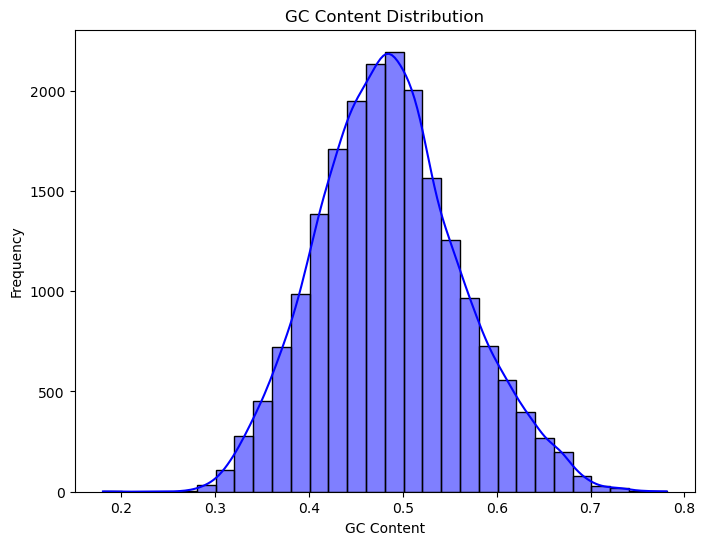

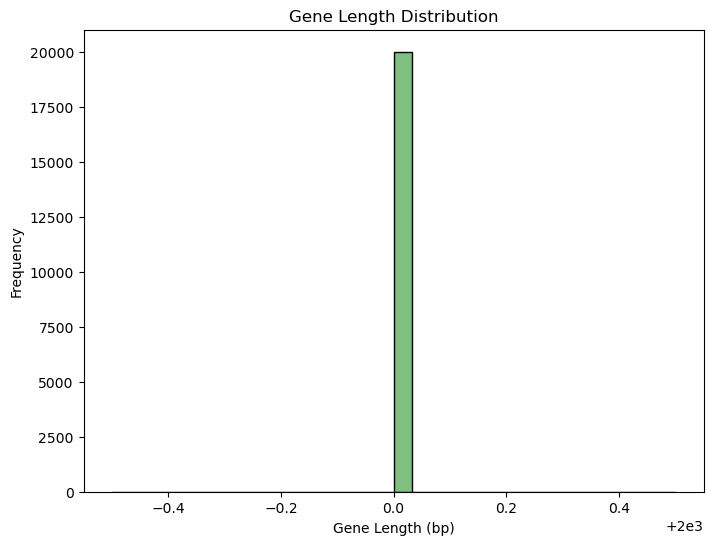

/tmp/ipykernel_189868/2096754813.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="TATA_Box", data=df, palette="pastel")


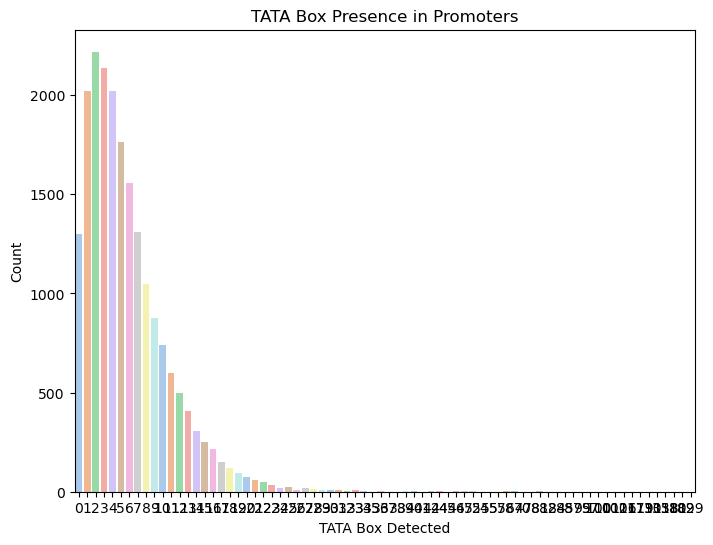

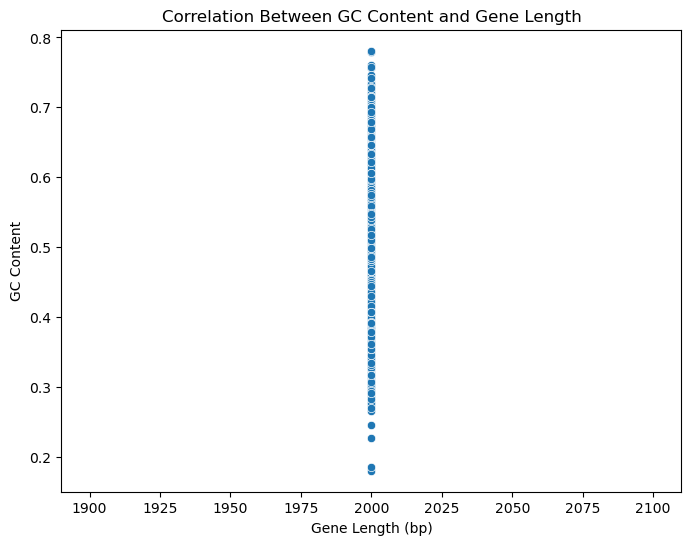

In [31]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Constants for file paths
CSV_FILE = "promoter_sequences.csv"  # Path to the already saved promoter sequences CSV file

# Function to process the loaded CSV data
def load_promoter_csv(csv_path):
    print(f"Loading promoter CSV from {csv_path}...")
    df = pd.read_csv(csv_path)
    print(f"Loaded {df.shape[0]} records from the CSV file.")
    return df

# Check promoter length (must be >= 2000 bp)
def check_promoter_length(promoter_seq, threshold=2000):
    return len(promoter_seq) >= threshold  # True for valid promoters (>=2000 bp)

# CpG island detection (CG content > 0.5 indicates a CpG island)
def detect_cpg_island(promoter_seq):
    cpg_count = sum([1 for i in range(len(promoter_seq) - 1) 
                     if promoter_seq[i:i+2] == 'CG'])
    cpg_content = cpg_count / len(promoter_seq)
    return cpg_content  # Return the proportion of CpG content

# Check for missing nucleotides (N's in the sequence)
def check_for_missing_nucleotides(promoter_seq):
    return 'N' in promoter_seq

# Function to calculate GC content of a sequence
def calculate_gc_content(promoter_seq):
    gc_count = promoter_seq.count('G') + promoter_seq.count('C')
    gc_content = gc_count / len(promoter_seq) if len(promoter_seq) > 0 else 0
    return gc_content

# Function to count motif occurrences in the promoter sequence
def count_motif_occurrences(promoter_seq, motif):
    return promoter_seq.count(motif)

# Function to apply thresholds and quantify motif presence
def apply_thresholds(df, motif_col, thresholds=[0.1, 0.2, 0.3]):
    for threshold in thresholds:
        df[f'{motif_col}_Threshold_{threshold}'] = df[motif_col].apply(lambda x: 1 if x >= threshold else 0)
    return df

# Function to perform quality assurance and update the dataframe
def perform_quality_assurance(df):
    # Apply functions to the dataframe
    df['Gene_Length'] = df['promoter_sequence'].apply(len)
    df['GC_Content'] = df['promoter_sequence'].apply(calculate_gc_content)
    df['TATA_Box'] = df['promoter_sequence'].apply(lambda x: count_motif_occurrences(x, "TATA"))  # Count TATA box occurrences
    df['CpG_Content'] = df['promoter_sequence'].apply(detect_cpg_island)  # Quantify CpG content
    
    df['Missing_Nucleotides'] = df['promoter_sequence'].apply(check_for_missing_nucleotides)
    
    # Drop records with missing nucleotides (N's)
    df_clean = df[~df['Missing_Nucleotides']].copy()  # Drop rows containing 'N' in the promoter sequence
    
    # Validate promoter length (>=2000 bp)
    df_clean['Valid_Promoter_Length'] = df_clean['promoter_sequence'].apply(check_promoter_length)

    # Apply thresholds for TATA box and CpG content
    df_clean = apply_thresholds(df_clean, 'TATA_Box', thresholds=[0.1, 0.2, 0.3])  # Example for TATA box
    df_clean = apply_thresholds(df_clean, 'CpG_Content', thresholds=[0.1, 0.2, 0.3])  # Example for CpG content

    # Save the updated dataframe to a new CSV file
    updated_csv = "updated_promoter_features_clean.csv"
    df_clean.to_csv(updated_csv, index=False)
    print(f"Updated and cleaned dataframe saved to {updated_csv}.")
    
    # Return the cleaned dataframe
    return df_clean

# Perform quality assurance and visualizations
def perform_visualizations(df):
    # Quality Assurance Analysis
    missing_nucleotides_count = df['Missing_Nucleotides'].sum()
    invalid_promoter_length_count = df['Valid_Promoter_Length'].sum()
    tata_box_count = df['TATA_Box'].sum()
    cpg_island_count = df['CpG_Content'].sum()

    # Print the comprehensive summary report
    print("\nQuality Assurance Report:")
    print(f"Number of records with missing nucleotides: {missing_nucleotides_count}")
    print(f"Number of valid promoters (>= 2kb): {invalid_promoter_length_count}")
    print(f"Number of promoters with a TATA box detected: {tata_box_count}")
    print(f"Number of promoters with a CpG island detected: {cpg_island_count}")
    
    # Descriptive statistics for GC content and Gene Length
    print("\nDescriptive statistics of Gene Length and GC Content:")
    print(df[['Gene_Length', 'GC_Content']].describe())

    # Visualizations:
    # 1. GC Content Distribution
    plt.figure(figsize=(8, 6))
    sns.histplot(df['GC_Content'], bins=30, kde=True, color='blue')
    plt.title("GC Content Distribution")
    plt.xlabel("GC Content")
    plt.ylabel("Frequency")
    plt.show()

    # 2. Gene Length Distribution
    plt.figure(figsize=(8, 6))
    sns.histplot(df['Gene_Length'], bins=30, kde=True, color='green')
    plt.title("Gene Length Distribution")
    plt.xlabel("Gene Length (bp)")
    plt.ylabel("Frequency")
    plt.show()

    # 3. TATA Box and CpG Island Presence
    plt.figure(figsize=(8, 6))
    sns.countplot(x="TATA_Box", data=df, palette="pastel")
    plt.title("TATA Box Presence in Promoters")
    plt.xlabel("TATA Box Detected")
    plt.ylabel("Count")
    plt.show()

    # 4. Correlation Between GC Content and Gene Length
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Gene_Length', y='GC_Content', data=df)
    plt.title("Correlation Between GC Content and Gene Length")
    plt.xlabel("Gene Length (bp)")
    plt.ylabel("GC Content")
    plt.show()

# Main workflow
def main():
    # Load the promoter CSV data
    df = load_promoter_csv(CSV_FILE)
    
    # Perform quality assurance and update the dataframe
    updated_df = perform_quality_assurance(df)
    
    # Perform visualizations on the updated dataframe
    perform_visualizations(updated_df)

# Execute the main function
main()


In [21]:
import pandas as pd

# Load the CSV file with promoter sequences
def load_promoter_csv(csv_path):
    print(f"Loading promoter CSV from {csv_path}...")
    df = pd.read_csv(csv_path)
    print(f"Loaded {df.shape[0]} records from the CSV file.")
    return df

# Check for missing nucleotides (N's) in the sequence and return the count
def check_for_missing_nucleotides(promoter_seq):
    return promoter_seq.count('N')

# Main function to check for issues
def check_promoter_issues(csv_file):
    df = load_promoter_csv(csv_file)
    
    # Keep track of any problematic records
    problematic_records = []

    # Loop through the dataframe and check each sequence
    for index, row in df.iterrows():
        promoter_sequence = row['promoter_sequence']
        
        # Check if the promoter sequence is less than 2kb or contains 'N'
        missing_nucleotides_count = check_for_missing_nucleotides(promoter_sequence)
        if len(promoter_sequence) < 2000 or missing_nucleotides_count > 0:
            problematic_records.append({
                'index': index,
                'gene_id': row['gene_id'],
                'promoter_sequence': promoter_sequence,
                'length': len(promoter_sequence),
                'missing_nucleotides_count': missing_nucleotides_count
            })
    
    # If any problematic records were found, print them
    if problematic_records:
        print("Found the following problematic promoter sequences:")
        for record in problematic_records:
            print(f"\nIndex: {record['index']}")
            print(f"Gene ID: {record['gene_id']}")
            print(f"Promoter Sequence (Length: {record['length']}): {record['promoter_sequence']}")
            print(f"Missing Nucleotides: {record['missing_nucleotides_count']}")
    else:
        # If no issues were found, print "We good!"
        print("all looks good")

# Run the check function on your promoter sequences CSV
check_promoter_issues("updated_promoter_features_clean.csv")


Loading promoter CSV from updated_promoter_features_clean.csv...
Loaded 20028 records from the CSV file.
all looks good


# Extract Biological Prior from Promoter Sequence Nuclotides 

list of **key motifs** and features that can be relevant for **promoter identification** tasks:

### 1. **TATA Box**
   - **Sequence**: TATAAA (or variations like TATATA, TATAAG, etc.)
   - **Location**: Typically found around 30-35 bp upstream of the transcription start site (TSS).

### 2. **CAAT Box**
   - **Sequence**: CCAAT
   - **Location**: Usually found around 70-80 bp upstream of the TSS.

### 3. **GC Box**
   - **Sequence**: GGGCGG, GGCGG, GGCAG, etc.
   - **Location**: Found in various promoters, especially housekeeping genes.

### 4. **CpG Island**
   - **Sequence**: A region with a high frequency of CpG dinucleotides (CpG: cytosine followed by guanine).
   - **Location**: CpG islands are typically found near gene promoters (often within the first few hundred base pairs upstream of the TSS) and are associated with **gene silencing** or **gene activation** depending on the methylation state.
   
   **Motif Features**:
   - A region with more than 50% GC content and more than 200 base pairs in length.
   - **Function**: The CpG island is a key feature for gene regulation and often linked to **DNA methylation** and **epigenetic control**. These islands are found in many **housekeeping genes** and genes with **high transcription activity**.

---

### 5. **BRE (TFIIB Recognition Element)**
   - **Sequence**: G/CG/CGG
   - **Location**: Typically located just upstream or downstream of the TATA box, at around -40 to -50 bp.
   
   **Function**: Recognized by **TFIIB**, an essential component of the transcription initiation complex, contributing to transcription initiation.

---

### 6. **MRE (Motif Recognition Element)**
   - **Sequence**: CGCG
   - **Location**: Typically found in the upstream region of the promoter.

   **Function**: Often involved in **transcription factor binding** that regulates **gene expression**.

---

### 7. **Polymerase II Promoter Element (PPE)**
   - **Sequence**: Often includes combinations of various short motifs (e.g., GC, TATA)
   - **Location**: Near the TSS
   
   **Function**: Associated with **RNA polymerase II** for eukaryotic transcription.

---

### 8. **Octamer Motif (Oct1)**
   - **Sequence**: ATTTGCAT
   - **Location**: Found in **TATA-less promoters**.

   **Function**: Plays a role in **binding transcription factors** that regulate **gene expression**.

---

### 9. **Sp1 Binding Site**
   - **Sequence**: GGGGCGGGG
   - **Location**: Found in many **housekeeping gene promoters** and is important for **transcription initiation**.

   **Function**: Binding site for the **Sp1 transcription factor**, which regulates **gene expression** in response to various cellular signals.

---

### 10. **RFX (Regulatory Factor X) Binding Site**
   - **Sequence**: CAAAAGAG
   - **Location**: Found in promoters of genes related to **immune response** and **development**.

---

### 11. **E-box (Enhancer Box)**
   - **Sequence**: CANNTG (where N is any nucleotide)
   - **Location**: Found in many **transcriptional enhancer regions** of genes.

   **Function**: The E-box is recognized by **basic helix-loop-helix (bHLH)** transcription factors and plays a role in regulating **cell differentiation** and **development**.

---

  
These motifs are the main regulatory elements in **promoter regions** and play a crucial role in transcription regulation.

In [6]:
import pandas as pd
import re

# Load the CSV file
file_path = 'updated_promoter_features_clean.csv'
df = pd.read_csv(file_path)

# Function to extract TATA Box motifs and count occurrences
def find_tata_box(promoter_sequence):
    tata_patterns = ['TATAAA', 'TATATA', 'TATAAG']
    found_motifs = []
    total_count = 0
    for pattern in tata_patterns:
        matches = re.findall(pattern, promoter_sequence)
        count = len(matches)
        total_count += count
        if count > 0:
            found_motifs.extend(matches)
    return ", ".join(found_motifs), total_count

# Function to extract CAAT Box motifs and count occurrences
def find_caat_box(promoter_sequence):
    pattern = r'CCAAT'
    matches = re.findall(pattern, promoter_sequence)
    count = len(matches)
    return ", ".join(matches), count

# Function to extract GC Box motifs and count occurrences
def find_gc_box(promoter_sequence):
    gc_patterns = ['GGGCGG', 'GGCGG', 'GGCAG']
    found_motifs = []
    total_count = 0
    for pattern in gc_patterns:
        matches = re.findall(pattern, promoter_sequence)
        count = len(matches)
        total_count += count
        if count > 0:
            found_motifs.extend(matches)
    return ", ".join(found_motifs), total_count

# Function to identify CpG Islands and count occurrences
def find_cpg_island(promoter_sequence):
    matches = re.findall(r'CG', promoter_sequence)
    count = len(matches)
    return ", ".join(matches), count

# Function to extract BRE (TFIIB) motifs and count occurrences
def find_bre(promoter_sequence):
    bre_patterns = ['GCG', 'CGG']
    found_motifs = []
    total_count = 0
    for pattern in bre_patterns:
        matches = re.findall(pattern, promoter_sequence)
        count = len(matches)
        total_count += count
        if count > 0:
            found_motifs.extend(matches)
    return ", ".join(found_motifs), total_count

# Function to extract MRE motifs and count occurrences
def find_mre(promoter_sequence):
    pattern = r'MRE'  # Placeholder for MRE motifs, modify as needed
    matches = re.findall(pattern, promoter_sequence)
    count = len(matches)
    return ", ".join(matches), count

# Function to extract PPE motifs and count occurrences
def find_ppe(promoter_sequence):
    pattern = r'PPE'  # Placeholder for PPE motifs, modify as needed
    matches = re.findall(pattern, promoter_sequence)
    count = len(matches)
    return ", ".join(matches), count

# Function to extract Octamer Motif and count occurrences
def find_octamer(promoter_sequence):
    pattern = r'ATTTGC'  # Octamer motif pattern (example: ATTTGC)
    matches = re.findall(pattern, promoter_sequence)
    count = len(matches)
    return ", ".join(matches), count

# Function to extract Sp1 Binding Site motifs and count occurrences
def find_sp1(promoter_sequence):
    pattern = r'GGGCGG'  # Placeholder for Sp1 binding motif, modify as needed
    matches = re.findall(pattern, promoter_sequence)
    count = len(matches)
    return ", ".join(matches), count

# Function to extract E-box motifs and count occurrences
def find_ebox(promoter_sequence):
    pattern = r'CANNTG'  # E-box motif pattern (example: CANNTG)
    matches = re.findall(pattern, promoter_sequence)
    count = len(matches)
    return ", ".join(matches), count

# Function to extract RFX Binding Site motifs and count occurrences
def find_rfx(promoter_sequence):
    pattern = r'RFX'  # Placeholder for RFX binding motif, modify as needed
    matches = re.findall(pattern, promoter_sequence)
    count = len(matches)
    return ", ".join(matches), count

# Function to extract motifs and prepare the biological prior data
def extract_motifs(df):
    biological_prior = []
    for index, row in df.iterrows():
        gene_id = row['gene_id']
        promoter_sequence = row['promoter_sequence']
        
        # Extract motifs and their counts
        tata_box, tata_count = find_tata_box(promoter_sequence)
        caat_box, caat_count = find_caat_box(promoter_sequence)
        gc_box, gc_count = find_gc_box(promoter_sequence)
        cpg_island, cpg_count = find_cpg_island(promoter_sequence)
        bre, bre_count = find_bre(promoter_sequence)
        mre, mre_count = find_mre(promoter_sequence)
        ppe, ppe_count = find_ppe(promoter_sequence)
        octamer, octamer_count = find_octamer(promoter_sequence)
        sp1, sp1_count = find_sp1(promoter_sequence)
        ebox, ebox_count = find_ebox(promoter_sequence)
        rfx, rfx_count = find_rfx(promoter_sequence)
        
        # Store the extracted data
        biological_prior.append({
            'gene_id': gene_id,
            'TATA Box (Sequences)': tata_box,
            'TATA Box (Count)': tata_count,
            'CAAT Box (Sequences)': caat_box,
            'CAAT Box (Count)': caat_count,
            'GC Box (Sequences)': gc_box,
            'GC Box (Count)': gc_count,
            'CpG Island (Sequences)': cpg_island,
            'CpG Island (Count)': cpg_count,
            'BRE (TFIIB) (Sequences)': bre,
            'BRE (TFIIB) (Count)': bre_count,
            'MRE (Sequences)': mre,
            'MRE (Count)': mre_count,
            'PPE (Sequences)': ppe,
            'PPE (Count)': ppe_count,
            'Octamer Motif (Sequences)': octamer,
            'Octamer Motif (Count)': octamer_count,
            'Sp1 Binding Site (Sequences)': sp1,
            'Sp1 Binding Site (Count)': sp1_count,
            'E-box (Sequences)': ebox,
            'E-box (Count)': ebox_count,
            'RFX Binding Site (Sequences)': rfx,
            'RFX Binding Site (Count)': rfx_count
        })
    
    # Convert to DataFrame
    biological_prior_df = pd.DataFrame(biological_prior)
    return biological_prior_df

# Extract motifs and prepare the biological prior DataFrame
biological_prior_df = extract_motifs(df)

# Save to CSV file
output_file = 'biological_prior_for_transformer_branch.csv'
biological_prior_df.to_csv(output_file, index=False)

# Display the result
print("Biological Prior DataFrame saved to:", output_file)


Biological Prior DataFrame saved to: biological_prior_for_transformer_branch.csv


In [6]:
import pandas as pd
import re

# Load the CSV file
file_path = 'updated_promoter_features_clean.csv'
df = pd.read_csv(file_path)

# General function to extract motifs with thresholds and optional sliding window
def find_motifs(promoter_sequence, patterns, threshold=1, window_size=None):
    """
    Extract motifs based on given patterns, optional thresholds, and sliding window.
    :param promoter_sequence: DNA sequence to analyze.
    :param patterns: List of patterns (strings or regexes).
    :param threshold: Minimum count for reporting.
    :param window_size: Optional sliding window size.
    :return: Matched motifs (string) and count.
    """
    if window_size:
        found_motifs = []
        for i in range(0, len(promoter_sequence) - window_size + 1, window_size):
            window = promoter_sequence[i:i + window_size]
            count = 0
            matches = []
            for pattern in patterns:
                matches += re.findall(pattern, window)
                count += len(matches)
            if count >= threshold:
                found_motifs.append(f"Window {i}-{i + window_size}: {', '.join(matches)}")
        return "; ".join(found_motifs), len(found_motifs)
    else:
        matches = []
        total_count = 0
        for pattern in patterns:
            match = re.findall(pattern, promoter_sequence)
            total_count += len(match)
            if total_count >= threshold:
                matches.extend(match)
        return ", ".join(matches), total_count

# Updated motif-specific functions with thresholds and expanded patterns
def find_tata_box(promoter_sequence, threshold=1):
    return find_motifs(promoter_sequence, ['TATAAA', 'TATATA', 'TATAAG'], threshold)

def find_caat_box(promoter_sequence, threshold=1):
    return find_motifs(promoter_sequence, [r'CCAAT'], threshold)

def find_gc_box(promoter_sequence, threshold=1):
    return find_motifs(promoter_sequence, ['GGGCGG', 'GGCGG', 'GGCAG'], threshold)

def find_cpg_island(promoter_sequence, threshold=5, window_size=200):
    return find_motifs(promoter_sequence, [r'CG'], threshold, window_size)

def find_bre(promoter_sequence, threshold=1):
    return find_motifs(promoter_sequence, ['GCG', 'CGG'], threshold)

def find_mre(promoter_sequence, threshold=1):
    return find_motifs(promoter_sequence, [r'AAAGGTG', r'GGTG'], threshold)

def find_ppe(promoter_sequence, threshold=1):
    return find_motifs(promoter_sequence, [r'TTTTT', r'CCCCC'], threshold)

def find_octamer(promoter_sequence, threshold=1):
    return find_motifs(promoter_sequence, [r'ATTTGCAT'], threshold)

def find_sp1(promoter_sequence, threshold=1):
    return find_motifs(promoter_sequence, [r'GGGCGG'], threshold)

def find_ebox(promoter_sequence, threshold=1):
    return find_motifs(promoter_sequence, [r'C[ACGT][ACGT]TG'], threshold)

def find_rfx(promoter_sequence, threshold=1):
    return find_motifs(promoter_sequence, [r'GAGACG'], threshold)

# Function to extract motifs and prepare the biological prior data
def extract_motifs(df):
    biological_prior = []
    for index, row in df.iterrows():
        gene_id = row['gene_id']
        promoter_sequence = row['promoter_sequence']

        # Extract motifs and their counts
        tata_box, tata_count = find_tata_box(promoter_sequence)
        caat_box, caat_count = find_caat_box(promoter_sequence)
        gc_box, gc_count = find_gc_box(promoter_sequence)
        cpg_island, cpg_count = find_cpg_island(promoter_sequence)
        bre, bre_count = find_bre(promoter_sequence)
        mre, mre_count = find_mre(promoter_sequence)
        ppe, ppe_count = find_ppe(promoter_sequence)
        octamer, octamer_count = find_octamer(promoter_sequence)
        sp1, sp1_count = find_sp1(promoter_sequence)
        ebox, ebox_count = find_ebox(promoter_sequence)
        rfx, rfx_count = find_rfx(promoter_sequence)

        # Store the extracted data
        biological_prior.append({
            'gene_id': gene_id,
            'TATA Box (Sequences)': tata_box,
            'TATA Box (Count)': tata_count,
            'CAAT Box (Sequences)': caat_box,
            'CAAT Box (Count)': caat_count,
            'GC Box (Sequences)': gc_box,
            'GC Box (Count)': gc_count,
            'CpG Island (Sequences)': cpg_island,
            'CpG Island (Count)': cpg_count,
            'BRE (TFIIB) (Sequences)': bre,
            'BRE (TFIIB) (Count)': bre_count,
            'MRE (Sequences)': mre,
            'MRE (Count)': mre_count,
            'PPE (Sequences)': ppe,
            'PPE (Count)': ppe_count,
            'Octamer Motif (Sequences)': octamer,
            'Octamer Motif (Count)': octamer_count,
            'Sp1 Binding Site (Sequences)': sp1,
            'Sp1 Binding Site (Count)': sp1_count,
            'E-box (Sequences)': ebox,
            'E-box (Count)': ebox_count,
            'RFX Binding Site (Sequences)': rfx,
            'RFX Binding Site (Count)': rfx_count
        })

    # Convert to DataFrame
    biological_prior_df = pd.DataFrame(biological_prior)
    return biological_prior_df

# Extract motifs and prepare the biological prior DataFrame
biological_prior_df = extract_motifs(df)

# Save to CSV file
output_file = 'biological_prior_with_thresholds.csv'
biological_prior_df.to_csv(output_file, index=False)

# Display the result
print("Biological Prior DataFrame saved to:", output_file)


Biological Prior DataFrame saved to: biological_prior_with_thresholds.csv


#  extract non-promoter sequences
## Key Strategy:

- Identify "Forbidden" Regions: We first define all regions that should not be sampled. This includes:

- The promoter regions themselves (2000 bp upstream of TSS).

- The gene bodies (from TSS/start to gene end) to avoid sampling coding or UTR regions directly associated with the protein-coding genes used for promoters.

- Merge Overlapping Forbidden Regions: Combine overlapping or adjacent forbidden intervals on each chromosome into larger blocks. This simplifies the sampling process.

- Identify "Allowed" Gaps: Determine the regions between the merged forbidden blocks on each chromosome. These are the potential source regions for non-promoters.

- Sample Randomly: Randomly select starting positions within these allowed gaps, ensuring the full 2000 bp sequence fits within the gap.

- Quality Control: Extract the sequence, verify its length is exactly 2000 bp, and check for the absence of 'N' characters.

- Collect and Save: Repeat until the desired number of non-promoter sequences (typically matching the number of promoter sequences) is collected.

In [3]:
import os
import re
import random
import pandas as pd
from tqdm import tqdm
from Bio.SeqIO.FastaIO import SimpleFastaParser

# --- Configuration ---
FASTA_FILE = "Homo_sapiens.GRCh38.dna.primary_assembly.fa"
GTF_FILE = "Homo_sapiens.GRCh38.110.gtf"
PROMOTER_FILE = "updated_promoter_features_clean.csv"
OUTPUT_FILE = "updated_non_promoter_sequences.csv"
SEED = 42
SEQUENCE_LENGTH = 2000

random.seed(SEED)

# --- Genome Loading ---
def load_genome(fasta_path):
    print(f"Loading genome from {fasta_path}...")
    genome = {}
    main_chroms = {str(i) for i in range(1, 23)} | {'X', 'Y'}

    with open(fasta_path, 'r') as handle:
        for title, seq in SimpleFastaParser(handle):
            chrom = title.split()[0]
            if chrom in main_chroms:
                try:
                    cleaned_seq = re.sub(r'[^ACGTN]', 'N', seq.upper())
                    genome[chrom] = cleaned_seq
                except MemoryError:
                    print(f"❌ Memory error on chromosome {chrom}. Skipping.")
    print(f"✅ Loaded {len(genome)} main chromosomes into memory.")
    return genome


# --- GTF Processing ---
def load_protein_coding_genes(gtf_path):
    print(f"Parsing GTF: {gtf_path}...")
    columns = ['seqname', 'source', 'feature', 'start', 'end',
               'score', 'strand', 'frame', 'attribute']
    gtf = pd.read_csv(gtf_path, sep='\t', comment='#', header=None, names=columns)
    gtf = gtf[gtf['feature'] == 'gene']
    gtf = gtf[gtf['attribute'].str.contains('gene_biotype "protein_coding"', na=False)]
    gtf['seqname'] = gtf['seqname'].astype(str)
    gtf = gtf[gtf['seqname'].isin([str(i) for i in range(1, 23)] + ['X', 'Y'])]
    return gtf

# --- Forbidden Region Calculation ---
def define_forbidden_regions(gtf_df, genome_lengths):
    forbidden = {chrom: [] for chrom in genome_lengths}

    for _, row in gtf_df.iterrows():
        chrom = str(row['seqname'])
        strand = row['strand']
        gene_start, gene_end = row['start'], row['end']
        if chrom not in genome_lengths:
            continue
        chrom_len = genome_lengths[chrom]

        if strand == '+':
            prom_start = max(0, gene_start - SEQUENCE_LENGTH)
            prom_end = gene_start
        else:
            prom_start = gene_end
            prom_end = min(chrom_len, gene_end + SEQUENCE_LENGTH)

        forbidden[chrom].append((min(prom_start, prom_end), max(prom_start, prom_end)))
        forbidden[chrom].append((min(gene_start, gene_end), max(gene_start, gene_end)))

    # Merge overlapping intervals
    merged = {}
    for chrom, regions in forbidden.items():
        if not regions:
            merged[chrom] = []
            continue
        regions.sort()
        merged_list = [regions[0]]
        for start, end in regions[1:]:
            last_start, last_end = merged_list[-1]
            if start <= last_end:
                merged_list[-1] = (last_start, max(last_end, end))
            else:
                merged_list.append((start, end))
        merged[chrom] = merged_list

    return merged

# --- Allowed Gaps ---
def get_allowed_gaps(merged_forbidden, genome_lengths):
    allowed = {}
    for chrom in merged_forbidden:
        gaps = []
        prev_end = 0
        for start, end in merged_forbidden[chrom]:
            if start - prev_end >= SEQUENCE_LENGTH:
                gaps.append((prev_end, start))
            prev_end = end
        if genome_lengths[chrom] - prev_end >= SEQUENCE_LENGTH:
            gaps.append((prev_end, genome_lengths[chrom]))
        if gaps:
            allowed[chrom] = gaps
    return allowed

# --- Sequence Sampler ---
def sample_non_promoters(genome, allowed_gaps, count, gtf):
    samples = []
    coords = set()
    chromosomes = list(allowed_gaps.keys())
    max_attempts = count * 100
    attempts = 0

    # Map chromosomes to gene_id from GTF
    gene_id_map = {str(row['seqname']): row['attribute'] for _, row in gtf.iterrows()}

    pbar = tqdm(total=count, desc="Sampling Non-Promoters")
    while len(samples) < count and attempts < max_attempts:
        attempts += 1
        chrom = random.choice(chromosomes)
        gap_start, gap_end = random.choice(allowed_gaps[chrom])
        max_start = gap_end - SEQUENCE_LENGTH
        if max_start <= gap_start:
            continue
        start = random.randint(gap_start, max_start)
        end = start + SEQUENCE_LENGTH

        if (chrom, start) in coords:
            continue

        seq = genome[chrom][start:end]
        if 'N' not in seq and len(seq) == SEQUENCE_LENGTH:
            # Use real gene_id from GTF
            gene_id = gene_id_map.get(chrom, f"NONPROMOTER_{chrom}_{start}")
            samples.append({
                'gene_id': gene_id,
                'seqname': chrom,
                'strand': '+',
                'promoter_sequence': seq,
                'start': start,
                'end': end
            })
            coords.add((chrom, start))
            pbar.update(1)
    pbar.close()

    if len(samples) < count:
        print(f"⚠️ Only sampled {len(samples)} valid sequences out of {count} requested.")
    else:
        print("✅ Successfully sampled all sequences.")
    return samples

# --- Main Workflow ---
def main():
    genome = load_genome(FASTA_FILE)
    genome_lengths = {chrom: len(seq) for chrom, seq in genome.items()}
    gtf = load_protein_coding_genes(GTF_FILE)

    promoter_df = pd.read_csv(PROMOTER_FILE)
    target_count = len(promoter_df)
    print(f"Target non-promoter sequence count: {target_count}")

    forbidden = define_forbidden_regions(gtf, genome_lengths)
    allowed = get_allowed_gaps(forbidden, genome_lengths)
    samples = sample_non_promoters(genome, allowed, target_count, gtf)

    if samples:
        df = pd.DataFrame(samples)
        df.to_csv(OUTPUT_FILE, index=False)
        print(f"✅ Saved non-promoter sequences to {OUTPUT_FILE}")
    else:
        print("❌ No sequences were saved. Sampling failed.")

if __name__ == "__main__":
    main()


Loading genome from Homo_sapiens.GRCh38.dna.primary_assembly.fa...
❌ Memory error on chromosome 6. Skipping.
✅ Loaded 18 main chromosomes into memory.
Parsing GTF: Homo_sapiens.GRCh38.110.gtf...


C:\Users\pc\AppData\Local\Temp\ipykernel_15696\1379566317.py:42: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(gtf_path, sep='\t', comment='#', header=None, names=columns)


Target non-promoter sequence count: 20028


Sampling Non-Promoters: 100%|█████████████████████████████████████████████████| 20028/20028 [00:01<00:00, 10798.61it/s]


✅ Successfully sampled all sequences.
✅ Saved non-promoter sequences to updated_non_promoter_sequences.csv


In [4]:
import pandas as pd

# --- Configuration ---
INPUT_CSV = "updated_non_promoter_sequences.csv"
CLEAN_OUTPUT = "non_promoter_sequences_clean.csv"
PROBLEM_OUTPUT = "non_promoter_sequences_problematic.csv"
EXPECTED_LENGTH = 2000

# --- Load the CSV ---
def load_sequences(csv_path):
    print(f"📥 Loading non-promoter sequences from '{csv_path}'...")
    df = pd.read_csv(csv_path)
    print(f"✅ Loaded {df.shape[0]} records.")
    return df

# --- Check a single sequence ---
def check_sequence_issues(seq):
    return len(seq) != EXPECTED_LENGTH or 'N' in seq

# --- Perform quality check ---
def quality_check(df):
    print("🔍 Performing quality check on non-promoter sequences...")

    valid_rows = []
    problematic_rows = []

    for _, row in df.iterrows():
        seq = row['promoter_sequence']
        if check_sequence_issues(seq):
            row_data = row.copy()
            row_data['actual_length'] = len(seq)
            row_data['missing_n_count'] = seq.count('N')
            problematic_rows.append(row_data)
        else:
            valid_rows.append(row)

    valid_df = pd.DataFrame(valid_rows)
    problem_df = pd.DataFrame(problematic_rows)

    print(f"\n📊 Quality Check Summary:")
    print(f"✅ Valid sequences: {len(valid_df)}")
    print(f"⚠️ Problematic sequences: {len(problem_df)}")

    return valid_df, problem_df

# --- Save results ---
def save_results(valid_df, problem_df):
    valid_df.to_csv(CLEAN_OUTPUT, index=False)
    problem_df.to_csv(PROBLEM_OUTPUT, index=False)
    print(f"\n💾 Saved valid sequences to '{CLEAN_OUTPUT}'")
    print(f"💾 Saved problematic sequences to '{PROBLEM_OUTPUT}'")

# --- Main ---
def main():
    df = load_sequences(INPUT_CSV)
    valid_df, problem_df = quality_check(df)
    save_results(valid_df, problem_df)

if __name__ == "__main__":
    main()


📥 Loading non-promoter sequences from 'updated_non_promoter_sequences.csv'...
✅ Loaded 20028 records.
🔍 Performing quality check on non-promoter sequences...

📊 Quality Check Summary:
✅ Valid sequences: 20028
⚠️ Problematic sequences: 0

💾 Saved valid sequences to 'non_promoter_sequences_clean.csv'
💾 Saved problematic sequences to 'non_promoter_sequences_problematic.csv'
